# Fig. 3



**Method**

- PC1 and 2 are the 1st and 2nd principal components of the natural image dataset.


Execution time: 10 secs

TO DO:
- prior is not zero mean but close -> keep like this?

## Setup 

setup fisher_info_limits2

In [51]:
# import packages
import os
import numpy as np
from numpy import exp, ceil, sqrt, log, pi, zeros, eye, linspace, meshgrid, trapezoid
from numpy.linalg import solve, slogdet, inv
from scipy.special import gammaln
import math
import scipy.io as sio
import matplotlib.pyplot as  plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Ellipse
from scipy.stats import wilcoxon, ks_2samp, multivariate_normal
from scipy.interpolate import griddata
from scipy.signal import convolve2d
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from scipy.stats import pearsonr, spearmanr
from numba import njit, prange
from scipy.stats import pearsonr
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

# set project path
main_dir = '/home/steeve/steeve/idv/code/fisher-info-limits'
os.chdir(main_dir)

# pipeline parameters
LOAD_METRICS = True
GRID_POS = 220

# path
CELL_DATA_PATH = 'data/contrast_cells/carlo_data_cellno2.mat' # raw cell receptive field data
METRICS_DATA_PATH = 'data/computed_contrast_cells/BDEvSSI_no2.npz' # precomputed metrics

# setup figure paraleters
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 8
plt.rcParams["lines.linewidth"] = 0.5
plt.rcParams["axes.linewidth"] = 0.5
plt.rcParams["axes.spines.top"] = False
plt.rcParams["xtick.major.width"] = 0.5 
plt.rcParams["xtick.minor.width"] = 0.5 
plt.rcParams["ytick.major.width"] = 0.5 
plt.rcParams["ytick.minor.width"] = 0.5
plt.rcParams["xtick.major.size"] = 3.5 * 1.1
plt.rcParams["xtick.minor.size"] = 2 * 1.1
plt.rcParams["ytick.major.size"] = 3.5 * 1.1
plt.rcParams["ytick.minor.size"] = 2 * 1.1

## Functions

In [72]:
# utils -----------------------------------------------------------

def vec(data: torch.tensor) -> torch.tensor:
    """flatten tensor in column-major order into
    a 2 dimensional tensor (N x 1)

    Args:
        data (torch.tensor): N x M array 

    Returns:
        (torch.tensor): ((N*M), 1) vector tensor
    """
    return data.T.flatten()[:,None]    


def sum2(data):
    """Sum over columns and keep 
    data dimensionality
    """
    return (data).sum(1, keepdims=True)


def create_gaussian_mask(grid_x, grid_y, mu, sigma, n_std=3):
    """
    Create a mask for points outside n standard deviations of a 2D Gaussian.
    
    Parameters
    ----------
    grid_x, grid_y : array_like
        Meshgrid coordinates
    mu : array_like
        Mean [mu_x, mu_y]
    sigma : array_like
        Covariance matrix (2x2)
    n_std : float
        Number of standard deviations
    
    Returns
    -------
    mask : array_like
        Boolean mask (True = inside, False = outside)
    """
    # Flatten grid for computation
    points = np.stack([grid_x.ravel(), grid_y.ravel()], axis=1)
    
    # Calculate Mahalanobis distance
    diff = points - mu
    inv_sigma = np.linalg.inv(sigma)
    mahal_dist_sq = np.sum(diff @ inv_sigma * diff, axis=1)
    
    # Points inside n_std satisfy: mahal_dist^2 <= n_std^2
    mask = mahal_dist_sq <= n_std**2
    return mask.reshape(grid_x.shape)


def logsumexp(a: np.array, axis=0):
    """
    Computes log(sum(exp(a), axis)) while avoiding numerical underflow.
    Equivalent to MATLAB's logsumexp by Tom Minka.

    Parameters
    ----------
    a : np.ndarray
        Input array.
    axis : int, optional
        Axis along which to sum. Default is 0.

    Returns
    -------
    s : np.ndarray
        Log-sum-exp of the input along the specified axis.
    """
    # find the maximum along the specified axis (for numerical stability)
    a_max = np.max(a, axis=axis, keepdims=True)

    # subtract and exponentiate
    a_stable = a - a_max
    s = a_max + log(np.sum(np.exp(a_stable), axis=axis, keepdims=True))

    # remove the extra dimension
    s = np.squeeze(s, axis=axis)
    a_max = np.squeeze(a_max, axis=axis)

    # handle non-finite max values (like -inf)
    return np.where(np.isfinite(a_max), s, a_max)


# 2D Poisson  -------------------------------------------


def SUM_LOG_LIST(position):
    '''Given an integer n it recursively calculates log(n!)'''
    if position == 0:
        return np.array([0])
    if position == 1:
        return np.append(SUM_LOG_LIST(0), 0)
    new_list = SUM_LOG_LIST(position-1)
    return np.append(new_list, new_list[-1]+np.around(np.log(float(position)), 8))


def POISSON_2DCELL(tc_grid, max_firing=20):
    log_list = np.tile(SUM_LOG_LIST(max_firing)[:,None,None], tc_grid.shape)
    log_tc = np.around(np.log(tc_grid), 8)#, where=(mask==1), out = np.ones_like(tc_grid)*-100)
    log_likelihood = (np.array([(i*log_tc-tc_grid) for i in range(max_firing+1)])-log_list)
    likelihood = np.exp(log_likelihood)
    likelihood = likelihood/np.sum(likelihood, axis=0)
    return likelihood    


# Neural encoder model ------------------------------------


def tuning_curve(x, mu=np.array([0.3, -1.2]), 
      Sigma_f=np.array([[1, 0.2], [0.2, 0.5]]), 
      Sigma_f2=np.array([[1, -0.4], [-0.4, 0.5]]), 
      amp=20):
    """Compute 2D tuning curve for a single neuron
    as a mixture of two Gaussians.

    The tuning curve models neural responses as a function of two stimulus dimensions
    (e.g., natural image principal components). It combines two Gaussian bumps with
    different centers and covariance structures, plus a baseline firing rate.    

    Args:
        x (np.array): Stimulus coordinates of shape (N, 2), where N is the number of points
        ...and the two columns represent PC1 and PC2 (or any 2D feature space).
        mu (np.array, optional): Center of the second Gaussian component, shape (2,). 
        ...Defaults to np.array([0.3, -1.2]).
        Sigma_f (np.array, optional): Covariance (2x2) for the first Gaussian 
        ...component centered at origin. Controls the shape and orientation of 
        ...the first tuning bump. 
        ...Defaults to np.array([[1, 0.2], [0.2, 0.5]]).
        Sigma_f2 (np.array, optional): Covariance matrix (2x2) for the second 
        ...Gaussian component centered at mu. Controls the shape and orientation 
        ...of the second tuning bump. 
        ...Defaults to np.array([[1, -0.4], [-0.4, 0.5]]). 
        amp (int, optional): Maximum amplitude (peak firing rate) 
        ...of the tuning curve in spikes/second. 
        ...Defaults to 20.

    Returns:
        np.array: Mean firing rates at each stimulus location (tuning curve), shape (N,).
        Values represent spikes/second, with a baseline of 2 spikes/s.
    """
    return amp * (exp(-0.5 * sum(x.T * solve(Sigma_f,x.T))) + exp(-0.5 * sum((x-mu).T * solve(Sigma_f2, (x-mu).T)))) / 2 + 2


# Neural network model of cell average response ---------------------------


class SimpleRegressor(nn.Module):
    def __init__(self):
        super(SimpleRegressor, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.model(x)
    

def nnet_fit(pcs, fit, test_size=0.2, seed=42, n_epochs=200, linspace=np.linspace(-3,3,301)):
    """Fit tuning curves with a neural network

    Args:
        pcs (_type_): principal components of the cell's receptive field
        fit (_type_): tuning curve
        test_size (float, optional): _description_. Defaults to 0.2.
        seed (int, optional): _description_. Defaults to 42.
        n_epochs (int, optional): _description_. Defaults to 200.

    Returns:
        _type_: _description_
    """
    # setup reproducibility
    torch.manual_seed(seed)

    # get the predictors and predicted data
    X = np.copy(pcs[:2]).T          # x and y
    y = np.copy(np.array(fit[0]))   # response to fit
    
    # normalize principal components
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # create train/test split
    X_train_np, X_test_np, y_train_np, y_test_np = train_test_split(
        X_scaled, y, test_size=test_size, random_state=seed)

    # convert to tensors
    X_train = torch.tensor(X_train_np, dtype=torch.float32, requires_grad=True)
    X_test  = torch.tensor(X_test_np, dtype=torch.float32, requires_grad=True)
    y_train = torch.tensor(y_train_np, dtype=torch.float32).view(-1, 1)
    y_test  = torch.tensor(y_test_np, dtype=torch.float32).view(-1, 1)

    # initialize model, loss, and optimizer
    model = SimpleRegressor()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    for epoch in range(n_epochs):
        model.train()
        optimizer.zero_grad()
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()

        if (epoch+1) % 20 == 0 or epoch == 0:
            model.eval()
            val_loss = criterion(model(X_test), y_test).item()
            print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}")

    # inference: evaluate on a grid for visualization
    model.eval()

    # calculate grid (will be used throughout)
    grid_x, grid_y = np.meshgrid(linspace, linspace)
    grid_input = np.column_stack((grid_x.ravel(), grid_y.ravel()))
    grid_input_scaled = scaler.transform(grid_input)

    # predict response
    with torch.no_grad():
        preds = model(torch.tensor(grid_input_scaled, dtype=torch.float32)).numpy()
        
    grad_X_tensor = torch.tensor(grid_input_scaled, dtype=torch.float32, requires_grad=True)
    output = model(grad_X_tensor)
    output.backward(torch.ones_like(output))
    grads = grad_X_tensor.grad.detach().numpy()
    return preds, model, grads, grid_x, grid_y, grid_input_scaled, grid_input


#  Plots -------------------------------------------------

def scatter_hist(x, y, ax, ax_histx, ax_histy, c = 'tab:blue', alpha = 1, htype = 'step'):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    ax.scatter(x, y,s=1, color=c)

    # now determine nice limits by hand:
    binwidth = 0.2
    xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
    print(xymax)
    lim = (np.rint((xymax+1)/binwidth) + 1) * binwidth

    bins = np.arange(-lim, lim + binwidth, binwidth)
    axx = ax_histx.hist(x, bins=bins, color=c)
    ax_histx.set_ylim(0,(axx[0].max()//100+1)*100)
    axy = ax_histy.hist(y, bins=bins, orientation='horizontal', color=c)
    ax_histy.set_xlim(0,(axy[0].max()//100+1)*100)


def plot_gaussian_ellipse(mean, cov, ax, n_std=1.0, **kwargs):
    
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    vals = vals[order]
    vecs = vecs[:, order]

    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
    width, height = 2 * n_std * np.sqrt(vals)
    
    ellipse = Ellipse(xy=mean, width=width, height=height, angle=theta, **kwargs)
    ax.add_patch(ellipse)
    return ax



# Information metrics -------------------------------------------------------

def compute_ssi(X, firingrate, dx, amp=20, Sigmax=np.array([[1,0.25], [0.25,1]])):
    """Compute SSI for stimulus distribution with zero mean 
    and given covariance matrix

    Args:
        X (_type_): _description_
        firingrate (_type_): _description_
        dx (_type_): _description_
        amp (int, optional): _description_. Defaults to 20.
        Sigmax (_type_, optional): _description_. Defaults to np.array([[1,0.25], [0.25,1]]).

    Returns:
        _type_: _description_
    """
    nx = int(sqrt(X.shape[0]))
    
    # Calculate log probability: log p(x) for multivariate Gaussian
    # log p(x) = -0.5 * (x^T * Sigma^(-1) * x) - 0.5 * log(det(2*pi*Sigma))
    # - inverse of covariance matrix
    Sigmax_inv = np.linalg.inv(Sigmax)                            

    # - Mahalanobis distance term: (x^T * Sigma^(-1) * x)
    # For multiple points in X (shape: 2 x N), compute for each column
    mahal_dist = np.sum(X.T * (Sigmax_inv @ X.T), axis=0)
    logpx = -0.5 * mahal_dist - 0.5 * np.linalg.slogdet(2 * np.pi * Sigmax)[1]

    # setup space of possible spike counts
    r = np.arange(0, amp + ceil(sqrt(amp*5))+1)[None] # of shape (n_neuron=1,31)

    # log p(r|x) of shape (nx**2, r.shape[1])
    logpr_x =  log( vec(firingrate) )*r - vec(firingrate) - sum(gammaln(r+1))   # OK!

    # log p(r,x) of shape (nx**2, r.shape[1])
    logprx = logpr_x + vec(logpx)

    # log p(r) of shape (n_neurons=1, r.shape[1])
    logpr = logsumexp(logprx + log(dx**2), 0)[None]

    # log p(x|r) of shape (nx**2, r.shape[1])
    logpx_r = logpr_x + vec(logpx) - logpr

    # H(X|r) of shape (n_neurons=1,31)
    HX_r = (-sum( exp(logpx_r) * logpx_r) * dx**2)[None]

    # SSI = H(X) - <H(X|r)>_p(r|x) of shape (nx, nx)
    # for a stimulus distribution with zero mean Gaussian with covariance matrix 
    ssi = 0.5 * slogdet(2*pi*exp(1)*Sigmax)[1] - HX_r @ exp(logpr_x).T                      # OK!
    ssi = ssi.reshape(nx,nx).T

    # I(R;X), a scalar
    Inf_ssi = vec(ssi).T @ exp(vec(logpx)) * dx**2
    return ssi, Inf_ssi, logpx, logpr_x, logpr


# unit-testing --------------------------------------------------

def test_f(x):

    # x points to plot, from -xmax to xmax
    nx = 100
    xmax = 10
    x = np.linspace(-xmax, xmax, nx)[None] # of shape (1,100)
    dx = x[0,1] - x[0,0]

    # transform into 2D stimulus (capitalized to show 2D)
    xtemp1, xtemp2 = np.meshgrid(x, x)
    X = np.column_stack((vec(xtemp1), vec(xtemp2))) # of shape (nx**2, 2)    

    # Parameters
    amp = 20                         # maximum firing rate
    Sigma_f = np.array([[1, 0.2], 
                        [0.2, 0.5]])
    Sigma_f2 = np.array([[1, -0.4], 
                        [-0.4, 0.5]])
    mu = np.array([0.3, -1.2])

    # test
    assert np.allclose(np.exp(-0.5 * sum(X.T * solve(Sigma_f, X.T))).mean(), 0.0104, atol=1e-4), "wrong"
    assert np.allclose(tuning_curve(X, mu, Sigma_f, Sigma_f2, amp).mean(), 2.1942)


def test_ssi(ssi, inf_ssi, logpx, logpr_x, logpr):

    assert np.allclose(logpx[:10], np.array([-81.80560781, -80.21121268, -78.66035052, -77.15302134,
    -75.68922512, -74.26896189, -72.89223162, -71.55903433,
    -70.26937001, -69.02323866])), "wrong logpx"

    assert np.allclose(logpr_x[:3,:3], np.array([[-2.        , -1.30685282, -1.30685282],
    [-2.        , -1.30685282, -1.30685282],
    [-2.        , -1.30685282, -1.30685282]])), "wrong logpr_x"

    assert np.allclose(logpr, np.array([ -4.004177  ,  -3.0262503 ,  -2.6462648 ,  -2.540976  ,
            -2.55821745,  -2.61336901,  -2.66757795,  -2.71162076,
            -2.74981398,  -2.79006207,  -2.84012527,  -2.90677374,
            -2.99569149,  -3.11148839,  -3.25774536,  -3.43710368,
            -3.65139045,  -3.90175929,  -4.18882754,  -4.51279853,
            -4.87356435,  -5.27078859,  -5.7039714 ,  -6.17249935,
            -6.67568333,  -7.21278685,  -7.78304701,  -8.38568994,
            -9.01994198,  -9.68503768, -10.38022546])), "Wrong logpr"

    # SSI
    assert np.allclose(ssi.mean(), -0.1210, atol=1e-4), "wrong SSI"
    assert np.allclose(inf_ssi, 0.5991, atol=1e-4), "wrong Inf_ssi"

## Unit-tests

100

In [ ]:
# unit-test
nx = 100
xmax = 10
x = np.linspace(-xmax, xmax, nx)[None] # of shape (1,100)
test_f(x)

## Load dataset

In [3]:
%%time 

# load one cell data
mat = sio.loadmat(CELL_DATA_PATH)
np.random.seed(10)

# get tuning curve data
pcs = mat['X_lowd'] # principal components
fit = mat['f']      # average firing rate (tuning)

CPU times: user 834 ms, sys: 87.9 ms, total: 922 ms
Wall time: 920 ms


## Prior of PCs

### Compute 

In [ ]:
%%time

# setup mean and covariance of the prior -----------------------------------

mu0 = pcs[0].mean()
mu1 = pcs[1].mean()
sigma = np.cov(pcs[0], pcs[1])

# fit the cell's tuning curve with a neural network -------------------------------

# we can get continuous predictions of average responses for arbitrary PC1 and 2 pairs
print("Fitting neural net to tuning curve data...")
preds, model, _, grid_x, grid_y, grid_input_scaled, grid_input = nnet_fit(pcs, fit)
with torch.no_grad():
    preds = model(torch.tensor(grid_input_scaled, dtype=torch.float32)).numpy()


# compute/load neural information metrics  ------------------------

# set parameters
baseline = 1e-2

# compute prior
mus = pcs[:2].mean(axis=1)
prior = multivariate_normal(mus, sigma)
grid_prior = prior.pdf(grid_input).reshape(grid_x.shape)/prior.pdf(grid_input).reshape(grid_x.shape).sum()
prior_entropy = -np.sum(grid_prior*np.around(np.log2(grid_prior), 8))

# get tuning curve
with torch.no_grad():
    preds = model(torch.tensor(grid_input, dtype=torch.float32)).numpy()[:,0]
tc = preds.reshape(grid_x.shape)+baseline

# compute likelihood
likelihood = POISSON_2DCELL(tc)

# compute posterior
evidence = np.sum(likelihood*np.tile(grid_prior[None,:,:], (likelihood.shape[0],1,1)), axis=(-1,-2))
posterior = likelihood*np.tile(grid_prior[None,:,:], (likelihood.shape[0],1,1))/\
                        np.tile(evidence[:,None,None], (1,*likelihood.shape[1:])) 
posterior[posterior==0] = 1e-50
posterior = posterior/np.tile(posterior.sum(axis=(1,2))[:,None,None], (1, *grid_x.shape))

# computing is slow for 300 x 300 grid (> 1 hour)
if not LOAD_METRICS:

    # compute SSI
    post_entropy = -np.sum(posterior*np.around(np.log2(posterior),8), axis=(1,2))
    ssi = prior_entropy - np.sum(likelihood * np.tile(post_entropy[:,None,None], (1, *grid_x.shape)) ,axis=0)

    # compute Bayes error
    mse = np.empty_like(posterior[0])
    for i in range(likelihood.shape[1]):
        for j in range(likelihood.shape[2]):
            post_ij = np.sum(posterior * np.tile(likelihood[:,i,j][:,None,None], (1, *likelihood.shape[1:])), axis=0)
            delta = (grid_x - grid_x[i,j])**2+(grid_y-grid_y[i,j])**2
            mse[i,j] = np.sum(post_ij*delta)
    rmse = np.sqrt(mse)
    print("Computed SSI and Bayes error.")

else: 
    # load precomputed metrics
    out = np.load(METRICS_DATA_PATH)
    ssi = out['ssi']
    mse = out['mse']
    rmse = np.sqrt(out['mse'])
    print("mse shape: ", mse.shape)
    print("grid shape: ", out['grid_x'].shape)
    print("Loaded precomputed data:", out.keys())

# compute SSI bound
ssi_bound = 2**(prior_entropy - ssi-2*np.log2(50))/(np.sqrt(2*np.pi*math.e))

Fitting neural net to tuning curve data...
Epoch 1/200, Train Loss: 0.2139, Val Loss: 0.2523
Epoch 20/200, Train Loss: 0.0625, Val Loss: 0.1091
Epoch 40/200, Train Loss: 0.0485, Val Loss: 0.0953
Epoch 60/200, Train Loss: 0.0411, Val Loss: 0.0864
Epoch 80/200, Train Loss: 0.0366, Val Loss: 0.0807
Epoch 100/200, Train Loss: 0.0332, Val Loss: 0.0766
Epoch 120/200, Train Loss: 0.0307, Val Loss: 0.0737
Epoch 140/200, Train Loss: 0.0288, Val Loss: 0.0712
Epoch 160/200, Train Loss: 0.0274, Val Loss: 0.0692
Epoch 180/200, Train Loss: 0.0263, Val Loss: 0.0672
Epoch 200/200, Train Loss: 0.0255, Val Loss: 0.0659
mse shape:  (301, 301)
grid shape:  (301, 301)
Loaded precomputed data: KeysView(NpzFile 'data/computed_contrast_cells/BDEvSSI_no2.npz' with keys: mse, posterior, ssi, grid_x, grid_y)
CPU times: user 6.49 s, sys: 282 ms, total: 6.77 s
Wall time: 729 ms


### Plot

5.8709399157428415
CPU times: user 551 ms, sys: 12 ms, total: 563 ms
Wall time: 562 ms


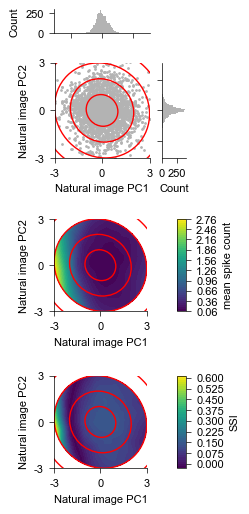

In [5]:
%%time

# setup parameters
xylim = (-3,3)
xyticks = (-3,0,3)

# Create mask for 3 standard deviations
mask_3std = create_gaussian_mask(out['grid_x'], out['grid_y'], np.array([mu0, mu1]), sigma, n_std=3)

# Apply mask to data
preds_masked = np.where(mask_3std, preds.reshape(out['grid_x'].shape), np.nan)
ssi_masked = np.where(mask_3std, ssi, np.nan)

# setup plot
fig = plt.figure(figsize=(1.7,6))

# create main GridSpec: 1 col, 3 rows
gs_main = gridspec.GridSpec(3,1, figure=fig, wspace=0, height_ratios=[1.5,1,1])

# First subplot: Stimulus pcs & histogram --------------------------------------------------------------------------------
gs_top = gridspec.GridSpecFromSubplotSpec(2, 2,
                                          subplot_spec=gs_main[0],
                                          width_ratios=[4, 1],
                                          height_ratios=[1, 4],
                                          hspace=0.5, wspace=0.2)

# create axes for the mosaic
axs = {}
axs['histx'] = fig.add_subplot(gs_top[0, 0])
axs['scatter'] = fig.add_subplot(gs_top[1, 0])
axs['histy'] = fig.add_subplot(gs_top[1, 1])

# plot scatter points and histograms
scatter_hist(pcs[0], pcs[1], axs['scatter'], axs['histx'], axs['histy'], c=(.7,0.7,0.7))
axs['scatter'].set_aspect('equal')
axs['scatter'].set_xlabel('Natural image PC1')
axs['scatter'].set_ylabel('Natural image PC2')
axs['scatter'].set_xlim(xylim)
axs['scatter'].set_ylim(xylim)
axs['scatter'].set_xticks(xyticks,xyticks)
axs['scatter'].set_yticks(xyticks,xyticks)

# plot prior (contours)
for n_std in np.arange(0, 5, 1):
    plot_gaussian_ellipse(np.array([mu0, mu1]), sigma,
                         axs['scatter'], n_std=n_std,
                         edgecolor='red', facecolor='None')

# aesthetics
axs['scatter'].spines[['top','right']].set_visible(False)
axs['histx'].spines[['top','right']].set_visible(False)
axs['histx'].set_ylabel('Count')
axs['histy'].spines[['top','right']].set_visible(False)
axs['histy'].set_xlabel('Count')

# Second subplot: Tuning curve and prior --------------------------------------------------------------------------------
ax_bottom = fig.add_subplot(gs_main[1])

# plot tuning curve as heatmap (MASKED - white outside 3 std)
im = ax_bottom.contourf(grid_x, grid_y, preds_masked, levels=50, cmap='viridis', extend='neither')
ax_bottom.set_facecolor('white')  # Set background to white for masked regions
# colorbar
divider = make_axes_locatable(ax_bottom)
cax = divider.append_axes("right", size="10%", pad=0.3)
cbar = plt.colorbar(im, cax=cax, label="mean spike count")

# plot prior as contours
for n_std in np.arange(0, 6, 1):
    plot_gaussian_ellipse(np.array([mu0, mu1]), sigma,
                         ax_bottom, n_std=n_std,
                         edgecolor='red', facecolor='None')

# formatting
ax_bottom.set_aspect('equal')
ax_bottom.spines[['right']].set_visible(False)
ax_bottom.set_xlabel("Natural image PC1")
ax_bottom.set_ylabel("Natural image PC2")
ax_bottom.set_xlim(xylim)
ax_bottom.set_ylim(xylim)
ax_bottom.set_xticks(xyticks,xyticks)
ax_bottom.set_yticks(xyticks,xyticks)
ax_bottom.spines[['top','right']].set_visible(False)

# Third subplot: plot SSI (MASKED - white outside 3 std) ----------------------------------------------------
ax_bottom3 = fig.add_subplot(gs_main[2])
im = ax_bottom3.contourf(out['grid_x'], out['grid_y'], ssi_masked, levels=50, cmap='viridis', extend='neither')

# formatting
ax_bottom3.set_facecolor('white')  # Set background to white for masked regions
ax_bottom3.set_xlim(xylim)
ax_bottom3.set_ylim(xylim)
ax_bottom3.set_xticks(xyticks,xyticks)
ax_bottom3.set_yticks(xyticks,xyticks)
# colorbar
divider = make_axes_locatable(ax_bottom3)
cax = divider.append_axes("right", size="10%", pad=0.3)
cbar = plt.colorbar(im, cax=cax, label='SSI')

# plot prior as contours
for n_std in np.arange(0, 6, 1):
    plot_gaussian_ellipse(np.array([mu0, mu1]), sigma,
                         ax_bottom3, n_std=n_std,
                         edgecolor='red', facecolor='None')
# formatting
ax_bottom3.set_xlabel("Natural image PC1")
ax_bottom3.set_ylabel("Natural image PC2")
ax_bottom3.set_aspect('equal')
ax_bottom3.spines[['top','right']].set_visible(False)

# format figure
fig.subplots_adjust(wspace=0.9, hspace=0.5)

# save figure
plt.savefig('figures/fig3.svg', bbox_inches = 'tight', transparent=True, dpi=400)
plt.savefig('figures/fig3.pdf', bbox_inches = 'tight', transparent=True, dpi=400)

# TODO: INTEGRATING ILOCAL

In [ ]:
# create 2D-stimulus X(PC1,PC2) -------------------------

# - x points to plot, from -xmax to xmax
nx = 100
xmax = 10
x = np.linspace(-xmax, xmax, nx)[None] # of shape (1,100)
dx = x[0,1] - x[0,0]
grid_x, grid_y = np.meshgrid(x,x)

# - get the first two PCs (2D-stimulus)
X = np.column_stack((vec(grid_x), vec(grid_y))) # shape (nx**2,2)


# create neuron 2D tuning curve f(PC1,PC2) ----------------------------

firingrate = tuning_curve(X).reshape(nx,nx).T # shape (nx,nx) 


# compute ssi ------------------------------------

# for stimulus distribution (p(x)) with zero mean and given covariance
sigma = np.array([[1, 0.25], [0.25, 1]])
SSI, Inf_ssi, logpx, logpr_x, logpr = compute_ssi(X, firingrate, dx, amp=20, Sigmax=sigma)

In [77]:
# unit-test
test_ssi(SSI, Inf_ssi, logpx, logpr_x, logpr)

## Compute $I_{local}$

Execution time: 17 min

In [78]:
%%time 

# compute int J_gamma(y) dgamma, b/w gamma = 0 and gamma = gamma0 -----------------------------

# limits for integration - this may need tweaking depending on snr etc.
ngamma = 100; 
gamma0 = 0.01
gamma_max = 200
eta = 1e-4
ny = 101        # discretisation of y = x+ sqrt(gamma)*noise. Adapt depending on gamma

# tuning curve
f0 = tuning_curve(X)

# compute numerical derivative, nabla_x f
f1 = tuning_curve(X + np.array([eta, 0])) # of shape (1, nx**2) # OK
f2 = tuning_curve(X + np.array([0, eta])) # of shape (1, nx**2) # OK
df = np.vstack([f1-f0, f2-f0]) / eta # of shape (2, nx**2)

# compute Ilocal ------------------------------------------------------------

# Ilocal0 =  int J_gamma(y) dgamma, from gamma_0 to gamma
Ilocal0 = zeros((nx**2, 1))

# loop over x
for i in range(nx**2):
    J = df[:,i][:,None] * df[:,i][:,None].T / f0[i] # fisher
    Ilocal0[i] = 0.5 * slogdet(eye(2) + J * gamma0 * sigma / (gamma0*eye(2)+sigma))[1]   #Ilocal0
Ilocal0 = Ilocal0.reshape(nx,nx).T

# number of gamma to loop through
gamma = exp(linspace(log(gamma0), log(gamma_max), ngamma))
dgamma = np.hstack([gamma[0], np.diff(gamma)])

# Jx = <J_gamma(y)>_p(y|x)
meanJry = zeros((nx**2, ngamma))

# initialize ilocal
Inf = zeros((ngamma, ngamma))

# loop over noise scales
for igamma in range(len(gamma)):
    
    # discretisation of y = x+ sqrt(gamma)*noise. Adapt depending on gamma
    ymax = xmax + 5 * sqrt(gamma[igamma]) # ok
    y = linspace(-ymax, ymax, ny) # ok
    dy = y[1] - y[0] # ok
    
    [ycord1, ycord2] = meshgrid(y, y)  # ok
    Y = np.hstack([vec(ycord1), vec(ycord2)]) # ok
    
    # firing rate in this new space
    firingrate = f(Y).reshape(ny, ny).T # Ok!

    # log p(x) in this new coordinate space
    logpx = -0.5 * sum(Y.T * solve(sigma, Y.T)).reshape(ny,ny).T - 0.5 * slogdet(2*pi*sigma)[1] # OK!

    # p(y|x=0), gaussian filter for convolution
    phi = exp(-0.5*(ycord1**2 + ycord2**2)/gamma[igamma]) / (2*pi*gamma[igamma]) # Ok!

    # p(y|x=eta) same as above, but increment x, for numerical derivative
    phi1 = exp(-0.5*((ycord1+eta)**2+ycord2**2)/gamma[igamma]) / (2*pi*gamma[igamma]) # Ok!
    phi2 = exp(-0.5*(ycord1**2+(ycord2+eta)**2)/gamma[igamma]) / (2*pi*gamma[igamma]) # Ok!

    # convolve p(x) with phi to get p(y)
    logpy = log( convolve2d(exp(logpx), phi, 'same')*(dy**2)) # Ok!

    # same thing, but with incremented x, for numerical derivative
    logpy1 = log( convolve2d(exp(logpx), phi1, 'same')*(dy**2)) # Ok!
    logpy2 = log( convolve2d(exp(logpx), phi2, 'same')*(dy**2)) # Ok!

    # J_R(y)
    Jry = zeros((ny, ny))
    
    # loop over spike counts
    for r in range(int(amp+ceil(sqrt(amp*5))+1)): 

        # log p(r|x)
        logpr_x = log(firingrate)*r - firingrate - gammaln(r+1)  # OK

        # p(r,x)
        prx = exp(logpr_x + logpx) # Ok!

        # convolve p(r,x) with phi(x) to get log p(r,y), then subtract
        # logp(y) to get log p(r|y)
        logpr_y = log( convolve2d(prx, phi, 'same')*(dy**2)) - logpy # Ok!

        # same as above but with incremented x, for numerical derivative
        logpr_y1 = log( convolve2d(prx, phi1, 'same')*(dy**2)) - logpy1 # Ok!
        logpr_y2 = log( convolve2d(prx, phi2, 'same')*(dy**2)) - logpy2 # Ok!

        # Jry = <(d logpr_y/dy)^2>_{p(r|y)} - sum over p(r|y)
        Jry = Jry + exp(logpr_y) * ((logpr_y2 - logpr_y)**2 + (logpr_y1 - logpr_y)**2)/(eta**2) # Ok!

    # p(y|x) - to go back to space of 'X'  of shape (nx**2, 10201)
    py_x = exp(-0.5*(sum2(X**2) - 2*X @ Y.T + sum2(Y**2).T)/gamma[igamma])/(2*pi*gamma[igamma]) # Ok!

    # meanJry_gamma(x) = <J_gamma(y)>_p(y|x) of shape (nx**2, len(gamma))
    meanJry[:, igamma] = (py_x @ vec(Jry) * (dy**2)).flatten() # Ok!

    # take numerical integral over gamma, to get Ilocal
    if igamma > 0:
        Ilocal = 0.5 * trapezoid(y=meanJry[:,:igamma+1], x=gamma[:igamma+1], axis=1).reshape(nx,nx).T + Ilocal0 # OK!
    else:
        Ilocal = Ilocal0

    # estimates
    logpx = -0.5*sum(X.T * solve(sigma, X.T)) - 0.5*slogdet(2*pi*sigma)[1] # of shape (nx**2,1) # Ok!
    Inf[igamma] = vec(Ilocal).T @ exp(vec(logpx)) * (dx**2)  # of shape (len(gamma))

CPU times: user 28min 57s, sys: 4min 25s, total: 33min 22s
Wall time: 17min 19s


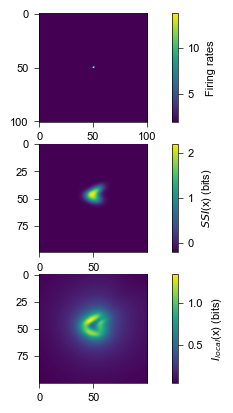

In [79]:
# fix ilocal
ax1 = plt.subplot(3, 1, 1)
im=plt.imshow(firingrate, cmap='viridis', aspect='equal')
plt.colorbar(im, ax=ax1, label='Firing rates')

# fix ilocal
ax2 = plt.subplot(3, 1, 2)
im=plt.imshow(SSI/log(2), cmap='viridis', aspect='equal')
plt.colorbar(im, ax=ax2, label='$SSI$(x) (bits)')

# fix ilocal
ax3 = plt.subplot(3, 1, 3)
im=plt.imshow(Ilocal/log(2), cmap='viridis', aspect='equal')
plt.colorbar(im, ax=ax3, label='$I_{local}$(x) (bits)')

## Controls

CPU times: user 28 ms, sys: 0 ns, total: 28 ms
Wall time: 27.5 ms


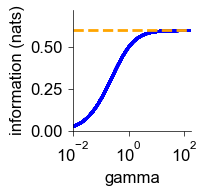

In [ ]:
%%time 

# plot convergence
plt.figure(2, figsize=(2,2))
plt.semilogx(gamma[:igamma], Inf[:igamma], 'b-', linewidth=2, label='plug in')
plt.axhline(Inf_ssi, color='orange', linestyle='--', linewidth=2, 
            label=r'$\int_0^\gamma \langle I_{\gamma}(x)\rangle_{p(x)} d\gamma$')
plt.xlabel('gamma', fontsize=12)
plt.ylabel('information (nats)', fontsize=12)
plt.ylim([0, 1.2 * Inf_ssi])
plt.xlim([gamma[0], gamma[igamma-1]])
plt.gca().spines[['top', 'right']].set_visible(False)
plt.tick_params(labelsize=12)
plt.tight_layout()

### unit-test ilocal

In [ ]:
# unit-test ilocal for igamma=0 and r=0

# fisher info
assert np.allclose(J, np.zeros((2,2)), atol=1e-6), 'Wrong J'

# ilocal
assert np.allclose(Ilocal0.max(), 0.0961, atol=1e-6), 'Wrong Ilocal0'
assert np.allclose(Ilocal0.mean(), 0.0013, atol=1e-4), 'Wrong Ilocal0'

assert np.allclose(dgamma[:10], np.array([0.01      , 0.0010521 , 0.00116279, 0.00128513, 0.00142033,
       0.00156977, 0.00173492, 0.00191745, 0.00211919, 0.00234215])), "Wrong dgamma for igamma=0"

assert np.allclose(gamma[:10], np.array([0.01      , 0.0110521 , 0.01221489, 0.01350001, 0.01492035,
       0.01649012, 0.01822504, 0.02014249, 0.02226168, 0.02460383])), "Wrong gamma for igamma=0"

# for igamma=0
# assert np.allclose(logpx[:3,:3], np.array([[-90.00560781, -88.26512781, -86.57168781],
#        [-88.26512781, -86.51288781, -84.80768781],
#        [-86.57168781, -84.80768781, -83.09072781]])), "Wrong logpx for igamma=0"
# logpy
assert np.allclose(logpy.mean(), -41.355489145119144), "wrong logpy"
assert np.allclose(logpy.max(), -1.7690594628954812), "wrong logpy"
assert np.allclose(logpy.min(), -146.91202131991633), "wrong logpy"
assert np.allclose(logpy[0,:2], np.array([-89.37694977, -87.63808617])), "wrong logpy"

# logpr_x
assert np.allclose(logpr_x.mean(), -2.176167841290246, atol=1e-6), "wrong logpr_x"

# logpr_y
assert np.allclose(logpr_y.mean(), -2.172208555883888, atol=1e-6), "wrong logpr_y"

# Jry
assert np.allclose(Jry.mean(), 0.0068690480743114838, atol=1e-6), "wrong Jry"

# py_x
assert np.allclose(py_x.mean(), 0.0022278918551180463, atol=1e-6), "wrong py_x"
assert np.allclose(py_x.max(), 15.915429354762148, atol=1e-6), "wrong py_x"

# meanJry
assert np.allclose(meanJry.mean(), 0.07453722243142574), "wrong py_x"

# Ilocal
assert np.allclose(Ilocal.mean(), 0.001337197219821242), "wrong Ilocal"
assert np.allclose(logpx.mean(), -38.0794574130235), "wrong logpx"

AssertionError: wrong logpy